<h1><center>Air-traffic prediction competition</center></h1>
<center>Maxime Redstone Leclerc - Hugo Ehlinger</center>

In [1]:
import problem
import pandas as pd
import numpy as np
from sklearn.preprocessing import FunctionTransformer
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from db.merge_transformer import MergeTransformer
from db.helpers import _encode_dates
from sklearn.metrics import mean_squared_error

from hyperopt import hp
from xgboost import XGBRegressor, XGBRFRegressor
import xgboost as xgb
from hyperopt import fmin, tpe, STATUS_OK, STATUS_FAIL, Trials

from estimator import _merge_external_data

fontsize = 18
params = {'axes.labelsize': fontsize,
          'font.size': fontsize,
          'legend.fontsize': fontsize,
          'xtick.labelsize': fontsize,
          'ytick.labelsize': fontsize,
          'figure.figsize': (12, 8)}
plt.rcParams.update(params)

import warnings
warnings.filterwarnings("ignore")

# <font color=darkblue> Project motivation

Being able to predict traffic is crucial to airlines as they modulate prices of flights based on predicted demand. These algorithms very much challenged during COVID-19 as people were not travelling as expected by the model and did not react to shifts in prices. This highlights the importance of having models able to accurately predict the number of passengers on a given flight.

# <font color=darkblue> Technical approach

## EDA

### Outliers

In [2]:
X_train, y_train = problem.get_train_data('..')
X_train.loc[:, 'DateOfDeparture'] = pd.to_datetime(X_train.loc[:, 'DateOfDeparture'])
y_train = pd.DataFrame(y_train, columns=['Passengers'])

Xy_train = X_train.copy()
Xy_train['Passengers'] = y_train

date_encoder = FunctionTransformer(_encode_dates)
Xy_train = date_encoder.fit_transform(Xy_train)

In [3]:
Xy_train.describe()

,WeeksToDeparture,std_wtd,Passengers,year,month,day,weekday,week,n_days,day_nb
count,8902.000000,8902.000000,8902.000000,8902.000000,8902.000000,8902.000000,8902.000000,8902.000000,8902.000000,8902.000000
mean,11.446469,8.617773,10.999048,2011.884071,6.860368,15.508537,2.964165,27.953831,15490.483712,193.133790
std,2.787140,2.139604,0.993945,0.572206,3.800044,8.875177,2.001616,16.508757,159.694164,116.027688
min,2.625000,2.160247,3.878108,2011.000000,1.000000,1.000000,0.000000,1.000000,15218.000000,1.000000
25%,9.523810,7.089538,10.427055,2012.000000,3.000000,8.000000,1.000000,11.000000,15351.000000,76.000000
50%,11.300000,8.571116,11.013357,2012.000000,8.000000,16.000000,3.000000,31.000000,15490.000000,213.000000
75%,13.240000,10.140521,11.592888,2012.000000,10.000000,23.000000,5.000000,43.000000,15630.000000,298.000000
max,23.163265,15.862216,14.007791,2013.000000,12.000000,31.000000,6.000000,52.000000,15769.000000,365.000000


We notice that some minimal values of 'Passengers' seem very far from Q1. We will investigate whether they are outliers to be removed or if the data is correct

Text(0, 0.5, 'Number of passengers')

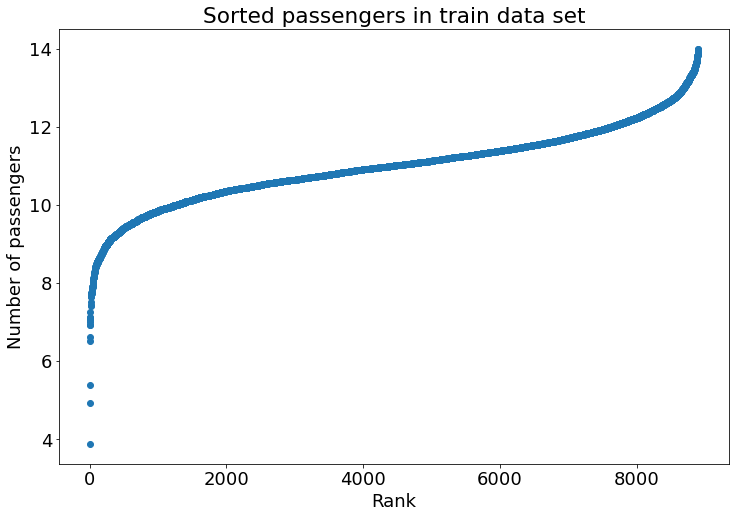

In [4]:
plt.scatter(range(len(Xy_train)), Xy_train[['Passengers']].sort_values(by=['Passengers']))
plt.title("Sorted passengers in train data set")
plt.xlabel("Rank")
plt.ylabel("Number of passengers")

This plot reveals 3 points below 6 "Passengers" in the custom scale

In [5]:
Xy_train.sort_values(by=['Passengers']).head()

,DateOfDeparture,Departure,Arrival,WeeksToDeparture,std_wtd,Passengers,year,month,day,weekday,week,n_days,day_nb
6486,2013-02-09,LGA,BOS,3.800000,2.774887,3.878108,2013,2,9,5,6,15745,40
6035,2012-12-31,BOS,LGA,4.800000,6.457554,4.921778,2012,12,31,0,1,15705,365
1903,2012-11-23,LGA,BOS,3.333333,3.265986,5.390473,2012,11,23,4,47,15667,327
1151,2012-07-14,BOS,LGA,5.750000,4.131759,6.520902,2012,7,14,5,28,15535,195
3856,2012-12-25,BOS,PHL,8.625000,4.991660,6.630638,2012,12,25,1,52,15699,359


Looking more closely, these four minimal points all concern the same route. Therefore, it seems that their low value is intrinsically related to this specific journey and we considered this data as valid. This leads us to investigate further the impact of the route on the number of passengers

### Routes

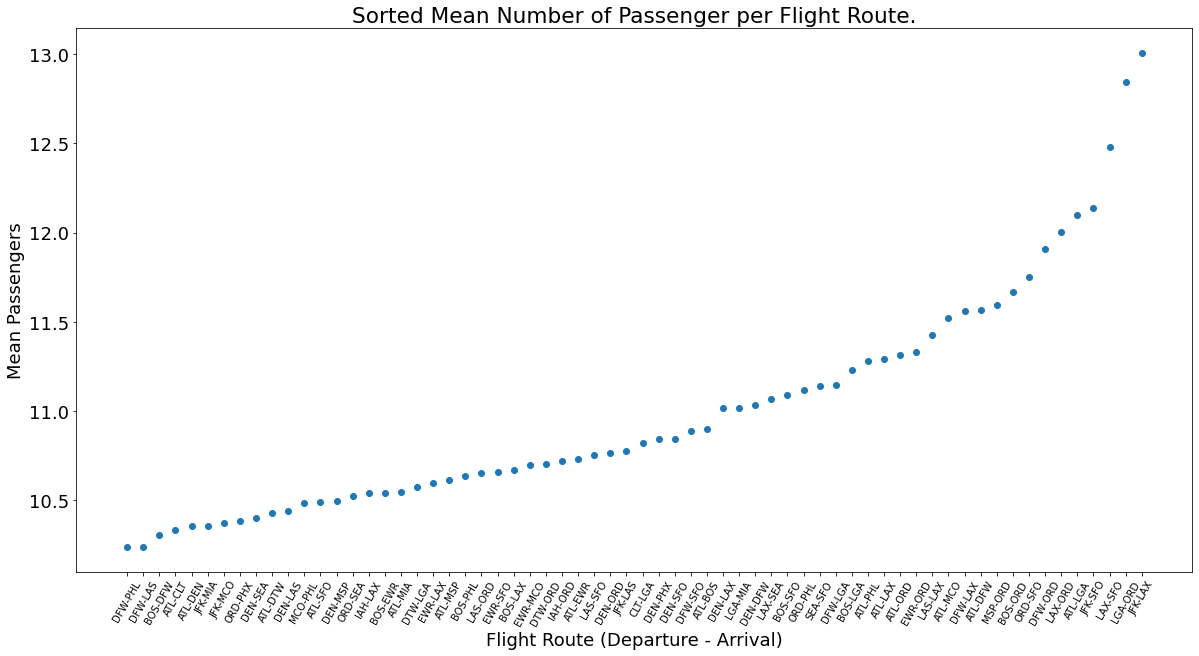

In [6]:
params = {'xtick.labelsize': 10}
plt.rcParams.update(params)


dep_list = Xy_train['Departure'].unique()
arr_list = Xy_train['Arrival'].unique()
routes = list(itertools.product(dep_list, arr_list))
routes = [tuple(sorted(t)) for t in routes]
routes = list(set(routes))

mean_list = []
routes_list = []
routes_str = []

dict_df = {}
for route in routes:
    dep_route = Xy_train.loc[Xy_train['Arrival'] == route[1]][Xy_train['Departure'] == route[0]]
    arr_route = Xy_train.loc[Xy_train['Arrival'] == route[0]][Xy_train['Departure'] == route[1]]
    df = pd.concat([dep_route, arr_route])
    if not df.empty:
        dict_df[route] = df

for k, v in dict_df.items():
    dep, arr = k
    routes_list.append(k)
    routes_str.append(dep + "-" + arr)
    mean_list.append(v['Passengers'].mean())

fig = plt.figure(figsize=(20, 10))

dict_means = {'route': routes_str, 'means': mean_list}
df_means = pd.DataFrame(dict_means)
df_means.sort_values(by='means', inplace=True)
plt.scatter(df_means['route'], df_means['means'])
plt.xticks(df_means['route'], rotation=60)
plt.xlabel("Flight Route (Departure - Arrival)")
plt.ylabel("Mean Passengers")
plt.title("Sorted Mean Number of Passenger per Flight Route.");

We notice that the different air routes seem to have structural differences in their average number of passengers carried per day. We expect this behaviour to remain in the testing set. Therefore, we think that this could be exploited in the model

### Dates

Text(0.5, 0, 'Day of the week')

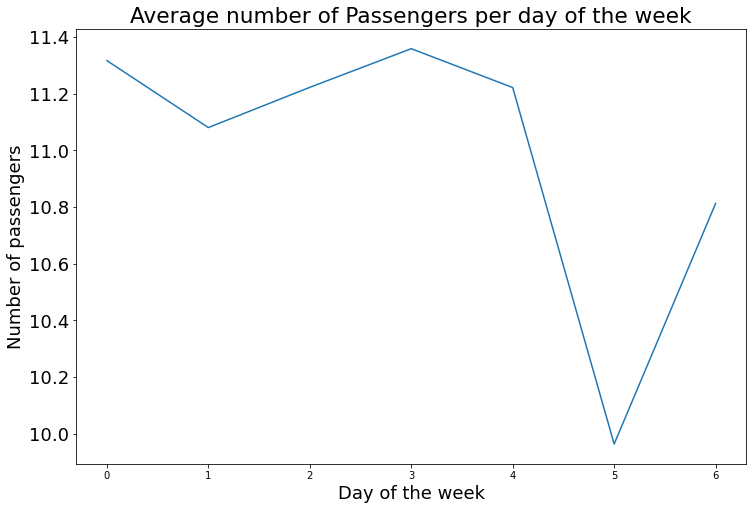

In [7]:
weekdays = pd.read_csv('../data/dates/weekdays_means.csv', sep=';')
weekdays = weekdays.sort_values(by=['weekday'])

plt.plot(weekdays[['weekday']], weekdays[['day_mean']])
plt.title("Average number of Passengers per day of the week")
plt.ylabel("Number of passengers")
plt.xlabel("Day of the week")

Text(0.5, 0, 'Week of the year')

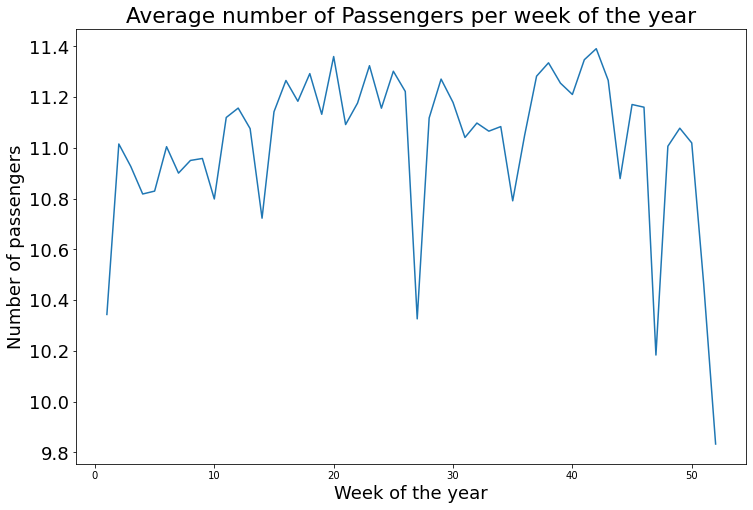

In [8]:
week = pd.read_csv('../data/dates/weeks_means.csv', sep=';')
week = week.sort_values(by=['week'])

plt.plot(week[['week']], week[['week_mean']])
plt.title("Average number of Passengers per week of the year")
plt.ylabel("Number of passengers")
plt.xlabel("Week of the year")

We notice a seasonality at difference time scales (weekdays, weeks, day of the year, etc.)

## External data

### Overview of our database

![title](../ER_Diagram.png)

We organized our external data sources in the above distinct tables for better clarity and scalability of the final merge to create external_data.csv

### Some interesting data sources

In [9]:
websearches = pd.read_csv('../data/airport_per_date/websearches.csv', sep=';', index_col='DateOfDeparture')
websearches = websearches.stack()
websearches = pd.DataFrame(websearches).reset_index()
websearches.rename({'level_1': 'AirPort', 0: 'search_intensity'}, axis=1, inplace=True)

In [10]:
websearches.describe()

,search_intensity
count,15900.000000
mean,55.623899
std,18.069289
min,14.000000
25%,42.000000
50%,56.000000
75%,69.000000
max,100.000000


Data from Google Trends. Indicates the intensity of weekly searches for keywords "closest city + flight" on a normalized scale (0-100). This scale enables to capture seasonality on a given airport whatever its intrinsic size. To be merged with DateBooked


## Modelling

### Feature engineering of given data

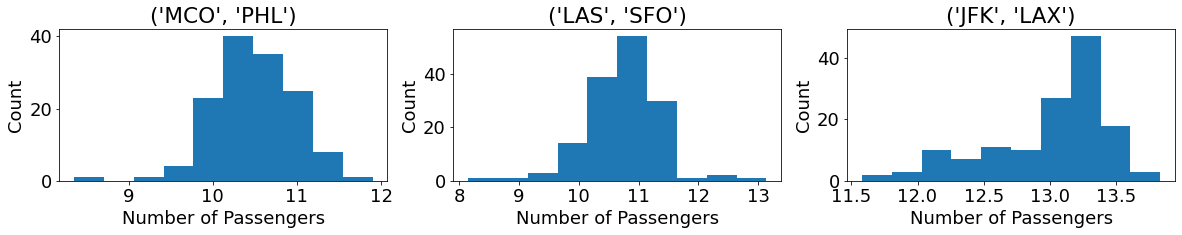

In [11]:
params = {'xtick.labelsize': fontsize}
plt.rcParams.update(params)

plt.subplots(1, 3, figsize=(20, 140), sharey=True)
i = 1

for k, v in dict_df.items():
    
    if k == ('LAS', 'SFO') or k == ('MCO', 'PHL') or k == ('JFK', 'LAX'):
        plt.subplot(42, 3, i)
        plt.ylabel("Count")
        plt.xlabel("Number of Passengers")
        plt.hist(v['Passengers'])
        plt.title(k)
        i += 1


We notice that the number of passengers per route seems to follow a Gaussian distribution. Therefore, considering the mean of each route as a feature should give a reasonable estimate of the true value. Furthermore, it enables us to convert 2 categorical features (Departure, Arrival) in one numerical feature while preserving the information about the specificity of the route.

Text(0.5, 0, 'Rank')

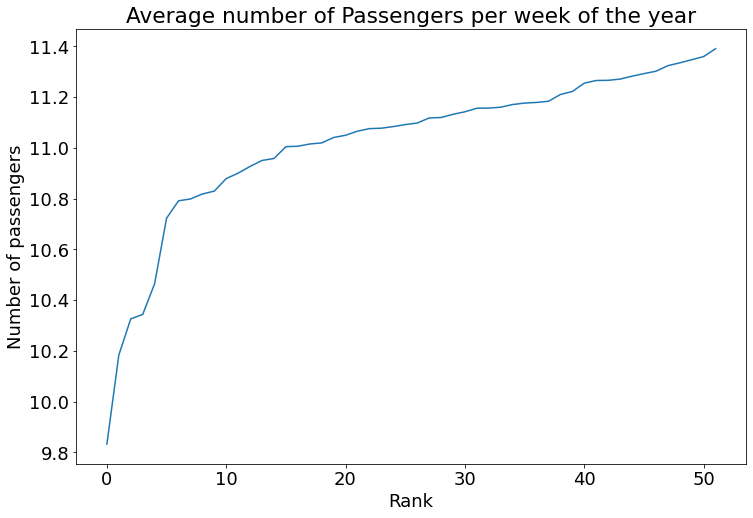

In [12]:
week = week.sort_values(by=['week_mean'])

plt.plot(range(len(week)), week[['week_mean']])
plt.title("Average number of Passengers per week of the year")
plt.ylabel("Number of passengers")
plt.xlabel("Rank")

### Model selection

Supervised learning problem predicting a continuous variable. 
Many features did not have a linear relationship with the target. A possibility could have been to make feature engineering to obtain linear relationships.
After ranking the encoded dates and the route-means, it was now easy for a decision tree to split the data efficiently. Therefore, this the path we explored.
In order to prevent overfitting from a single decision tree, we chose RandomForestRegressors, which are more robust. We used the XGBoost implementation of the RandomForestRegressor and used its sci-kit learn wrapper to put the model inside our pipeline.

In [13]:
xgb_reg_params = {
    'learning_rate':    hp.choice('learning_rate',    np.arange(0.01, 0.7, 0.01)),
    'max_depth':        hp.choice('max_depth',        np.arange(5, 16, 1, dtype=int)),
    'min_child_weight': hp.choice('min_child_weight', np.arange(1, 8, 1, dtype=int)),
    'colsample_bytree': hp.choice('colsample_bytree', np.arange(0.5, 1.0, 0.1)),
    'subsample':        hp.uniform('subsample', 0.6, 1),
    'n_estimators':     hp.choice('n_estimators', np.arange(1000, 8000, 1000)),
}

xgb_fit_params = {
    'eval_metric': 'rmse',
    'early_stopping_rounds': 10,
    'verbose': False
}

xgb_para = {}
xgb_para['reg_params'] = xgb_reg_params
xgb_para['fit_params'] = xgb_fit_params
xgb_para['loss_func' ] = lambda y, pred: np.sqrt(mean_squared_error(y, pred))

### Large Model

In [14]:
X_train, y_train = problem.get_train_data('..')
X_test, y_test = problem.get_test_data('..')

X_train_merged = _merge_external_data(X_train)
X_test_merged = _merge_external_data(X_test)

X_train_data = X_train_merged
X_test_data = X_test_merged

In [15]:
xg_reg = xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree=0.9, learning_rate=0.01, 
                          n_estimators=5000, max_depth=8, min_child_weight=3, subsample=0.8666220148202693, booster='gbtree')

xg_reg.fit(X_train_data, y_train)

preds = xg_reg.predict(X_test_data)
rmse = np.sqrt(mean_squared_error(y_test, preds))

RMSE: 0.317660


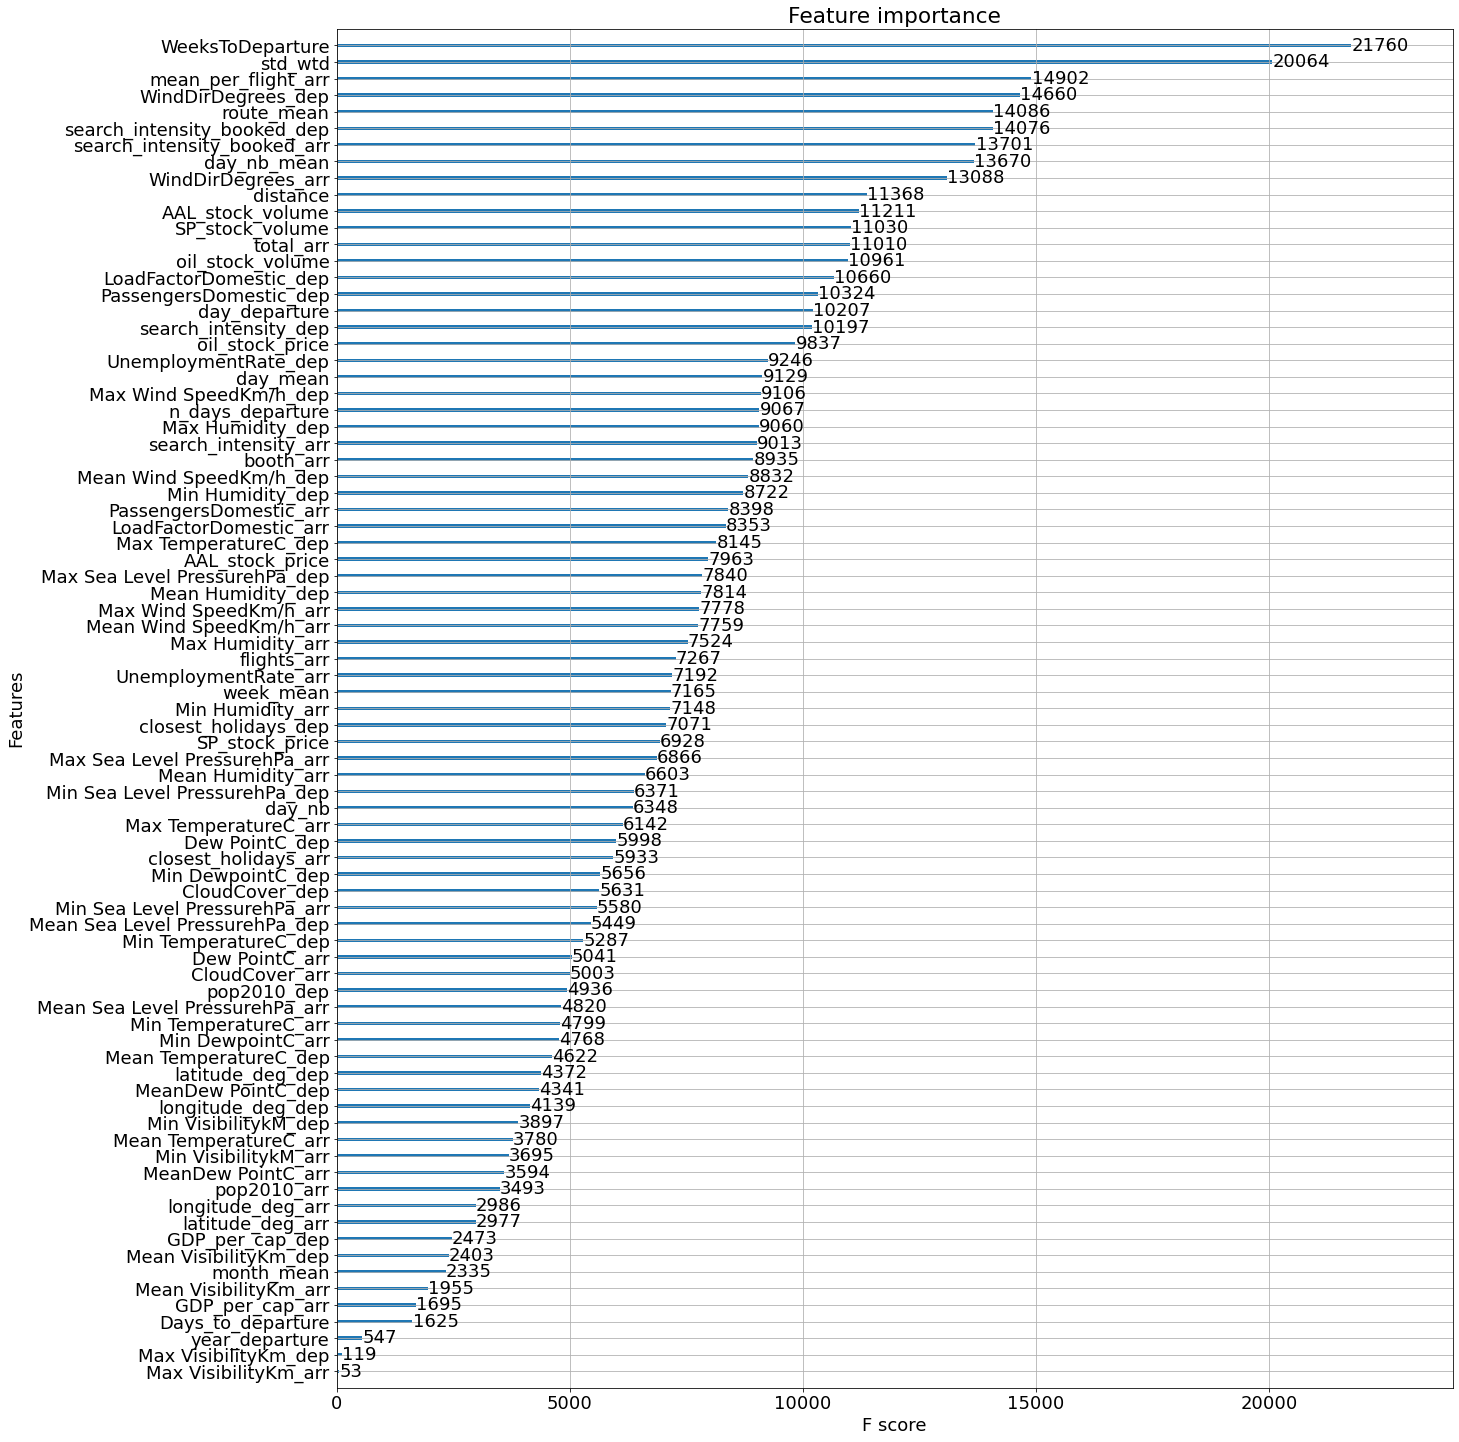

In [18]:
print("RMSE: %f" % (rmse))
plt.rcParams['figure.figsize'] = [20, 25]
xgb.plot_importance(xg_reg)
plt.show()

### Small Model

In [21]:
features_to_keep = ['route_mean', 'day_nb_mean', 'day_mean', 'week_mean', 
                    'month_mean', 'search_intensity_booked_dep', 
                    'search_intensity_booked_arr', 'total_arr', 'flights_arr', 'booth_arr', 
                    'mean_per_flight_arr']

In [37]:
xg_reg = xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree=0.9, learning_rate=0.075, 
                          n_estimators=250, max_depth=7, min_child_weight=6, subsample=0.98, booster='gbtree')

xg_reg.fit(X_train_data[features_to_keep], y_train)

preds = xg_reg.predict(X_test_data[features_to_keep])
rmse = np.sqrt(mean_squared_error(y_test, preds))

RMSE: 0.399691


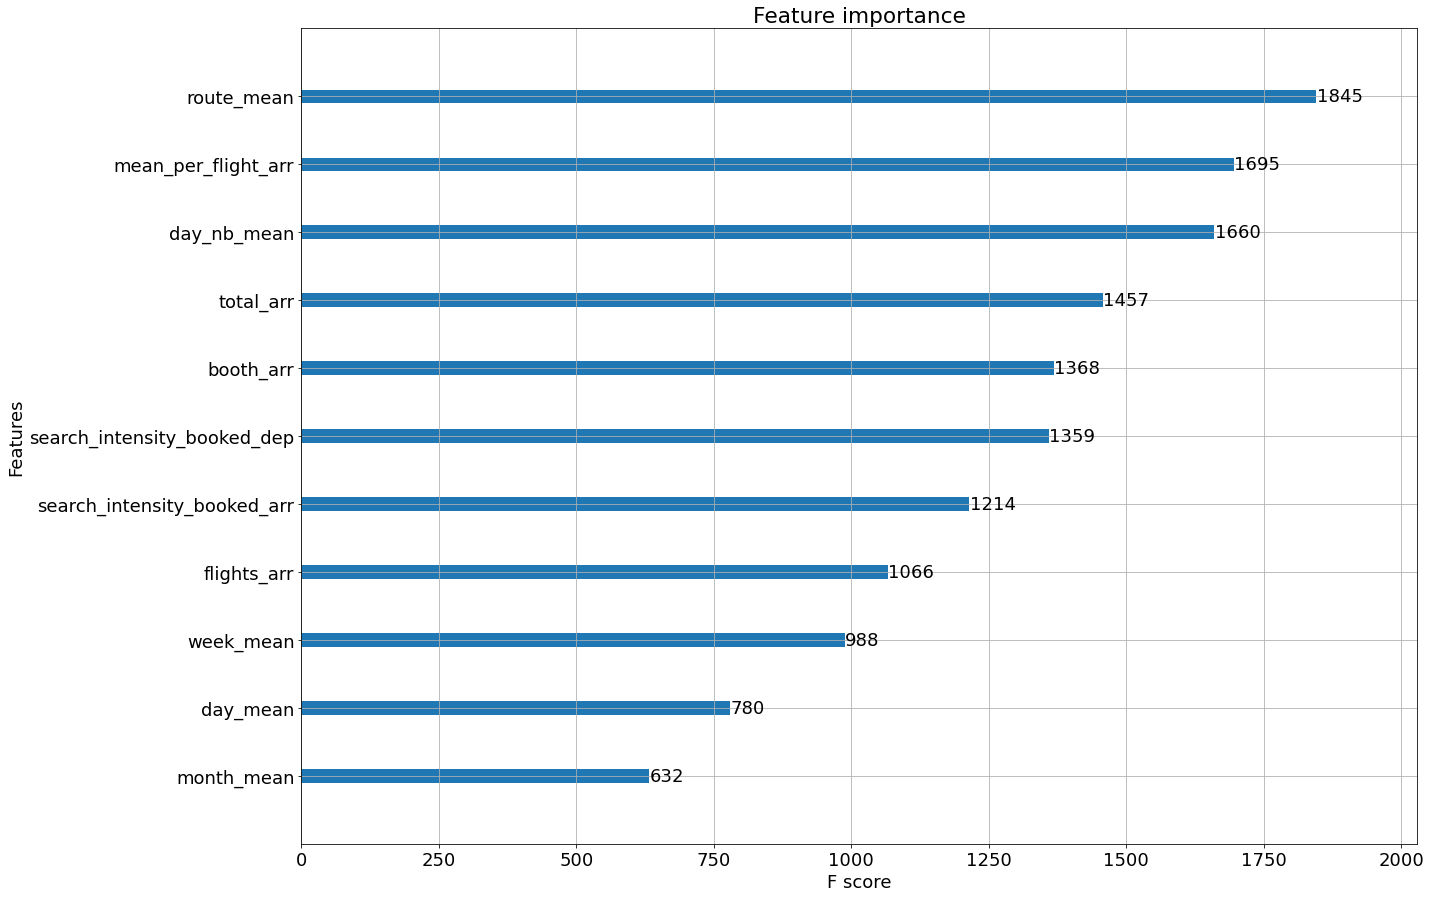

In [39]:
print("RMSE: %f" % (rmse))
plt.rcParams['figure.figsize'] = [20, 15]
xgb.plot_importance(xg_reg)
plt.show()

# <font color=darkblue> Results and future works

We obtain an RMSE = 0.318 for the large scale model which converted on RAMP to RMSE = 0.264. 

We can clearly see the different important features used by our XGBoost model. F-score is the number of times the feature is used to split a node in the tree. We find that the most relevant features are:
- Weeks To Departure
- Mean Flight Arrival
- Route Mean
- Search Intensity Booked
- Distance

Some are much less used such as:
- GDP per Capita
- Longitude
- Latitude
- Month Mean

<h3> Trade-off </h3>

We have shown two different types of models. A large scale model as discussed previously and a small scale model that yields a RMSE = 0.399 with a RAMP score of RMSE = 0.294. 

We  found  that adding the whole set of additional features led to a more accurate prediction although this naturally increased the execution time of our model.  As can be seen on our RAMP submissions,claque_au_sol_13 yields the best RMSE (0.264) but involves a long training and validation time (order of 1000’s and 100’s respectively) while claque_au_sol_10 computes a slightly higher RMSE (0.294) but is much more efficient with a training and validation time of the order of 10’s and 1’s respectively).

Reaching  a  sound  trade-off  depends  on  the  business  problem  at  hand.   In  a  context  of  constantly incoming new data, which could be the case for air travel companies, training/retraining the model has to be done regularly which emphasizes the need for a efficient training process. In a context where predictions accuracy is the main objective, a more complex model could be prefered

<h3> Overfitting </h3>

The grid-search conducted on the parameters has led to choosing hyperparameters that led to more overfitting (colbysample_tree, subsample and max_depth increased). This improved our prediction error on the leaderboard but at the cost of overfitting the testing set on RAMP (static). For a model to be put into production, we require our model to be more robust to new testing samples and remove some predictors. 

<h3> Future Works </h3>

Despite adding substantial amount of external data, this did not lead to a great gain in performance and we assume other data could explain better the number of passengers travelling per flight. We would have liked to explore the predictions given by more complex models such as Neural Networks.

Project can be found at: <https://github.com/hehlinge42/air_traffic_project>